In [1]:
# 1. CARGA DE LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 2. CARGA DE DATOS
path_tsm = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos TSM consultoria estadística.xlsx'
path_chla = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Base de datos Chla consultoria estadística.xlsx'
path_coords = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\Coordenadas zona costera occidental GC.csv'
path_oni = r'C:\Users\Lenovo\Desktop\MCD\2025-1\Estadistica\ae-oceanografia-golfo-cali\data\raw\oni-Cold & Warm Episodes by Season.csv - Sheet1.csv'

tsm_df = pd.read_excel(path_tsm)
chla_df = pd.read_excel(path_chla)
coords_df = pd.read_csv(path_coords, header=None)
oni_df = pd.read_csv(path_oni)


In [7]:
# 3. PREPROCESAMIENTO BÁSICO
# Convertir fecha
for df in [tsm_df, chla_df]:
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    df.set_index('FECHA', inplace=True)
    df['EVENTO INTERANUAL'] = df['EVENTO INTERANUAL'].replace({'Neutro': 'Neutral', 'Normal': 'Neutral'})

# Obtener nombres de estaciones
est_cols = [col for col in tsm_df.columns if 'Est' in col]

In [9]:
# 4. CÁLCULO DE CLIMATOLOGÍA Y ANOMALÍAS

def calcular_anomalias(df, col_est):
    clim = df.groupby(df.index.month)[col_est].mean()
    anom = df[col_est].copy()
    for m in range(1, 13):
        idx = df.index.month == m
        anom[idx] = df.loc[idx, col_est] - clim.loc[m]
    return anom

tsm_anom = calcular_anomalias(tsm_df, est_cols)
chla_anom = calcular_anomalias(chla_df, est_cols)

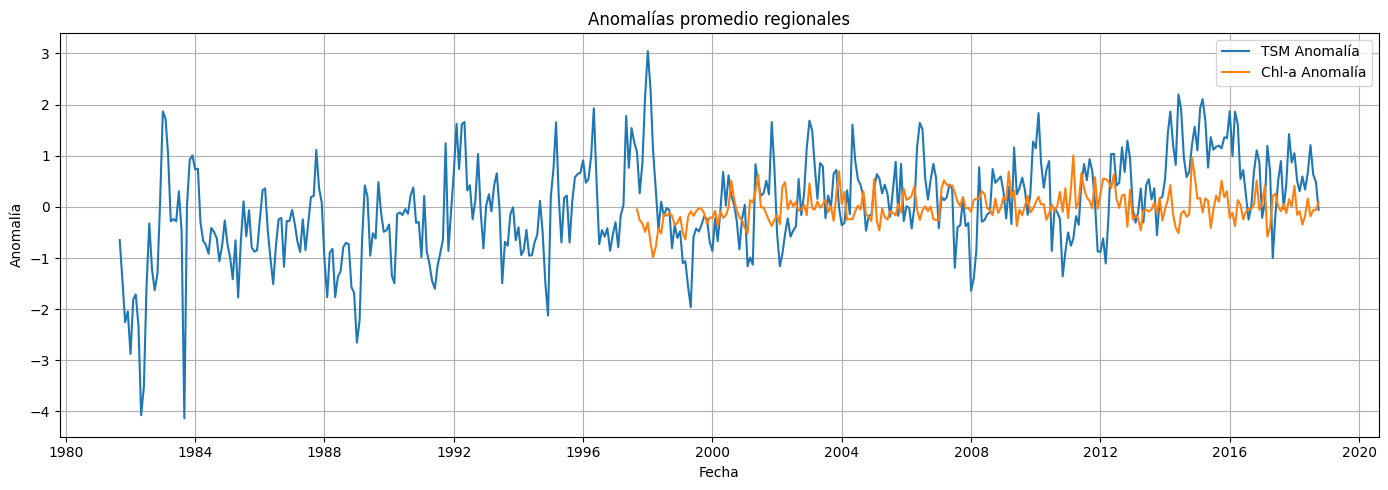

In [10]:
# 5. VISUALIZACIÓN DE SERIES TEMPORALES PROMEDIO
plt.figure(figsize=(14,5))
plt.plot(tsm_anom.mean(axis=1), label='TSM Anomalía')
plt.plot(chla_anom.mean(axis=1), label='Chl-a Anomalía')
plt.title('Anomalías promedio regionales')
plt.xlabel('Fecha')
plt.ylabel('Anomalía')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

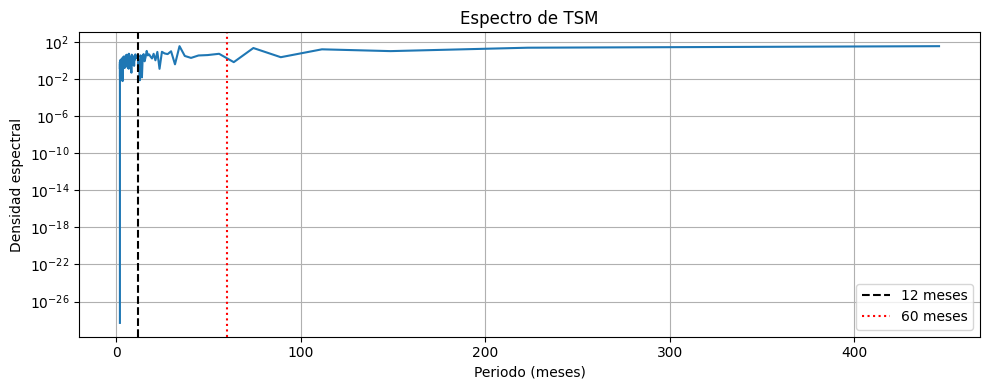

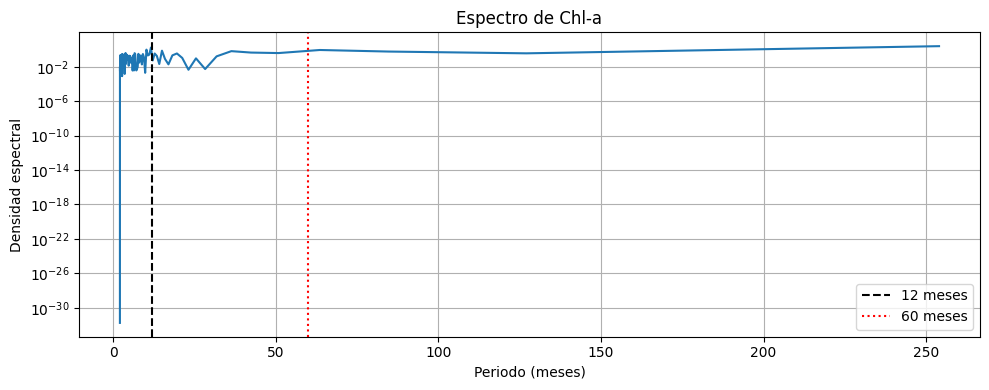

In [11]:
# 6. ANÁLISIS ESPECTRAL (FFT)
from scipy.signal import periodogram

def analisis_fft(serie, title):
    freqs, power = periodogram(serie, fs=1)  # mensual
    plt.figure(figsize=(10,4))
    plt.semilogy(1/freqs[1:], power[1:])
    plt.axvline(12, color='k', linestyle='--', label='12 meses')
    plt.axvline(60, color='r', linestyle=':', label='60 meses')
    plt.title(f'Espectro de {title}')
    plt.xlabel('Periodo (meses)')
    plt.ylabel('Densidad espectral')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analisis_fft(tsm_anom.mean(axis=1).dropna(), 'TSM')
analisis_fft(chla_anom.mean(axis=1).dropna(), 'Chl-a')



In [12]:
# 7. CLUSTERING DE SERIES
# Normalizar cada serie (por columna)
scaler = StandardScaler()
tsm_scaled = scaler.fit_transform(tsm_anom.fillna(0).T)

# Aplicar K-means (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(tsm_scaled)

# Asignar etiquetas a estaciones
cluster_map = pd.DataFrame({'Estacion': est_cols, 'Cluster': clusters})
print("Cluster asignado a cada estación:")
print(cluster_map.sort_values('Cluster'))



Cluster asignado a cada estación:
   Estacion  Cluster
7   Est 8°         0
6   Est 7°         0
5    Est 6°        0
4    Est 5°        0
9   Est 10°        0
10  Est 11°        0
8    Est 9°        0
11  Est 12°        1
12  Est 13°        1
13  Est 14°        1
2    Est 3°        2
3    Est 4°        2
0    Est 1°        2
1    Est 2°        2
14  Est 15°        3
15  Est 16°        3
16  Est 17°        3


<Figure size 800x400 with 0 Axes>

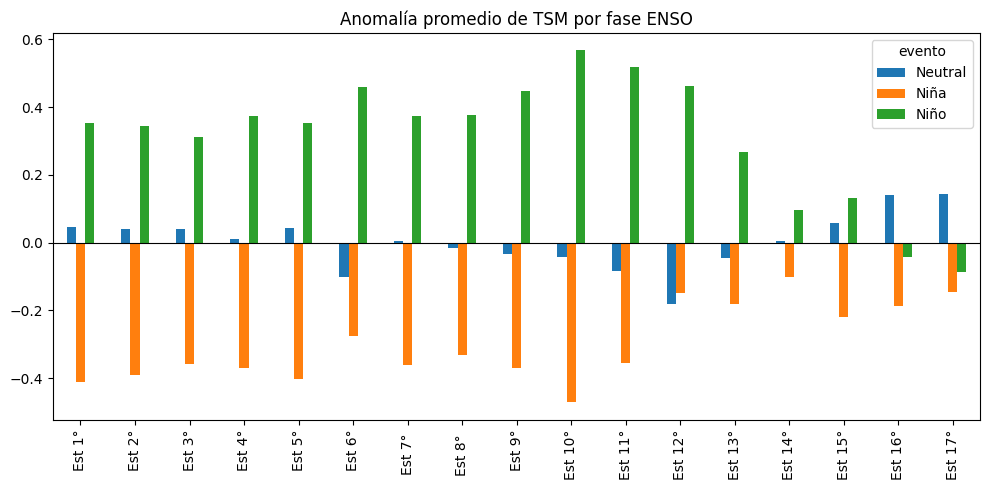

In [13]:
# 8. IMPACTO ENSO
# Cálculo de promedio por evento
tsm_df_event = tsm_anom.copy()
tsm_df_event['evento'] = tsm_df['EVENTO INTERANUAL']
ensoprom = tsm_df_event.groupby('evento')[est_cols].mean().T

plt.figure(figsize=(8,4))
ensoprom.plot(kind='bar', figsize=(10,5), title='Anomalía promedio de TSM por fase ENSO')
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

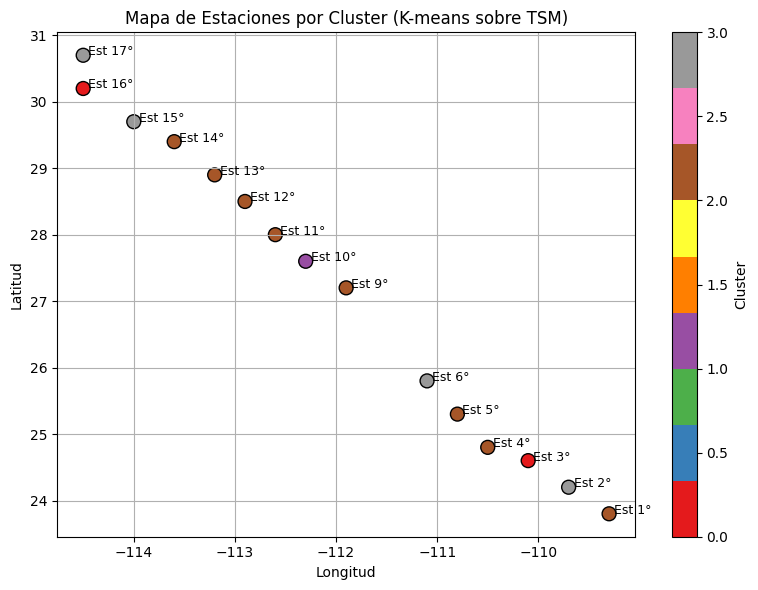

In [14]:
# Identificar columnas de estaciones
est_cols = [col for col in tsm_df.columns if 'Est' in col]

# Crear clusters falsos para graficar (en práctica vienen del clustering previo)
import numpy as np
np.random.seed(42)
clusters = np.random.randint(0, 4, size=len(est_cols))
cluster_map = pd.DataFrame({'Estacion': est_cols, 'Cluster': clusters})

# Preparar coordenadas
coords = coords_df.copy()
coords.columns = ['lon', 'drop', 'lat']
coords = coords.drop(columns=['drop']).reset_index(drop=True)
coords['Estacion'] = ['Est ' + str(i+1) + '°' for i in range(len(coords))]

# Unir coordenadas con clusters
coords_clusters = coords.merge(cluster_map, on='Estacion')

# Graficar mapa
plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords_clusters['lon'], coords_clusters['lat'], c=coords_clusters['Cluster'], cmap='Set1', s=100, edgecolor='k')
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Mapa de Estaciones por Cluster (K-means sobre TSM)")
plt.grid(True)

# Etiquetas
for _, row in coords_clusters.iterrows():
    plt.text(row['lon'] + 0.05, row['lat'], row['Estacion'], fontsize=9)

plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()